### Smoothed Bathymetry SVB - Domain 03 

Even longer domain to the north and extended to the west to see if there are any propagaing signals north of the bay. 

Depth has been smoothed to get a very idealized bathymetry w/o the effect of rough topographic features. 

Data from GEBCO Compilation Group (2020) GEBCO 2020 Grid (doi:10.5285/a29c5465-b138-234d-e053-6c86abc040b9).

Domain 3 is bounded by

* north: 34.1 N 
* south: 27.0 N
* east: -119.0 W
* west -114.0 W

Other considerations
* Bottom depth flattened to -5000 m. 
* Land set to 0 m. - fixed small puddles on land.
* Erased some weird artifacts from the measurement tracks.
* No Ojo de Liebre lagoon
* Smoothed out islands in SoCal, ridges, etc 

Grid
* Horizontal resolution: -0.01563 deg (~1.7 km, check!)
* nx=320, ny=454, nz=100, 
* Boundaries open to the W and S.

OPEN BOUNDARIES: West and South

In [1]:
from cartopy import crs as ccrs
import cartopy as cpy
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sci_interp
%matplotlib inline

In [2]:
nc_file = '../../bathy/GEBCO_SVB/GEBCO_2020_10_Feb_2021_824964c84a3d/gebco_2020_n36.0_s26.0_w-122.0_e-113.5.nc'

with Dataset(nc_file, 'r') as nbl:
    print(nbl.variables)

{'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
    sdn_parameter_urn: SDN:P01::ALATZZ01
    sdn_parameter_name: Latitude north
    sdn_uom_urn: SDN:P06::DEGN
    sdn_uom_name: Degrees north
unlimited dimensions: 
current shape = (2400,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
    sdn_parameter_urn: SDN:P01::ALONZZ01
    sdn_parameter_name: Longitude east
    sdn_uom_urn: SDN:P06::DEGE
    sdn_uom_name: Degrees east
unlimited dimensions: 
current shape = (2040,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'elevation': <class 'netCDF4._netCDF4.Variable'>
int16 elevation(lat, lon)
    standard_name: height_above_reference_ellipsoid
    long_name: Elevation relative to sea level
    units: m
    sdn_pa

In [3]:
with Dataset(nc_file, 'r') as nbl:
    lat = nbl.variables['lat'][:]
    lon = nbl.variables['lon'][:]
    elev = nbl.variables['elevation'][:]

In [4]:
#for ii,loni in zip(range(len(lon)),lon):
#    print(ii,loni)

In [5]:
## Set domain corners
lon1 = 719
lon2 = 1919
lat1 = 240
lat2 = 1944

## Flatten out bottom at 5000 m, land at 0 m
elev[elev > 0] = 0
elev[elev < -5000] = -5000

## Flatten out NE corner in the Gulf of California
elev[lat2-640:lat2+3, lon2-550:lon2+3] = 0
elev[lat2-1110:lat2-640, lon2-300:lon2+3] = 0

## Remove Ojo de Liebre lagoon
elev[lat1+145:lat1+180, lon2-80:lon2+3] = 0
elev[lat1+180:lat1+210, lon2-80:lon2+3] = 0
elev[lat1+180:lat1+225, lon2-75:lon2+3] = 0


/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


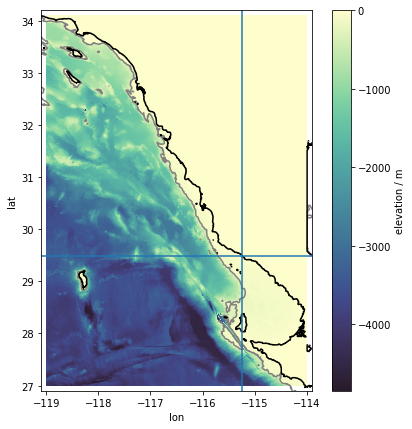

In [6]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
pc = ax.pcolormesh(lon[lon1:lon2],lat[lat1:lat2], elev[lat1:lat2,lon1:lon2], cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc)
cn = ax.contour(lon, lat, -elev, colors='0.5', levels=[250])
cn = ax.contour(lon, lat, -elev, colors='k', levels=[0])
ax.axhline(lat[lat2-1110])
ax.axvline(lon[lon2-300])

cb.set_label('elevation / m')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_xlim(-119.1,-113.9)
ax.set_ylim(26.9,34.2)
ax.set_aspect(1)

**Map above**: Colormesh of proposed domain 1 with land set to 0 m and bottom depth flattened at -5000 m (max depth found is 5083 m).  Black contour at 0 m depth, gray contour at -250 m depth (shelf break). There are some weird features I need to erase. For example, the track lines (I think they come from the measurement tracks) in the "trench" between the main continental shelf, and multiple coastline features on the southeast coast of the bay that I won't be able to resolve.    

In [7]:
nx = 320
ny = 456

lon_vect = np.round(np.linspace(-119.0,-114.0,nx+1), decimals=5)
lat_vect = np.round(np.linspace(27.0,34.1,ny+1), decimals=5)

f_interp = sci_interp.interp2d(lon,lat,elev)

In [8]:
bathy = f_interp(lon_vect,lat_vect)

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


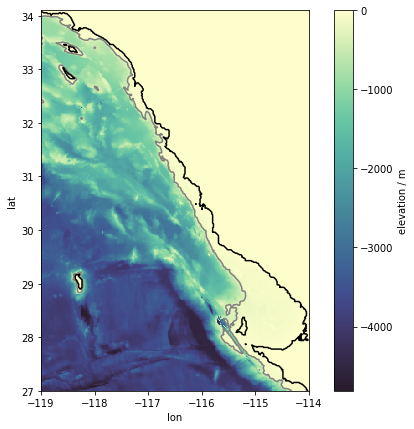

In [9]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
pc = ax.pcolormesh(lon_vect, lat_vect, bathy, cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc)
ax.contour(lon_vect,lat_vect, -bathy, colors='0.5', levels=[250])
ax.contour(lon_vect,lat_vect,  -bathy, colors='k', levels=[0])

cb.set_label('elevation / m')
ax.set_xlabel('lon')
ax.set_ylabel('lat')

ax.set_aspect(1)

In [10]:
def smooth(array):
    filtered = (array[:-1,1:]+array[1:,1:]+array[1:,:-1]+array[1:,1:])/4
    return(filtered)

In [11]:
smooth_bathy = (smooth(bathy))

# Add walls 
smooth_bathy[:,-1] = 0 # east
#smooth_bathy[0,:] = 0 # south
smooth_bathy[-1,:] = 0 # north
#smooth_bathy[:,0] = 0 # west


/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


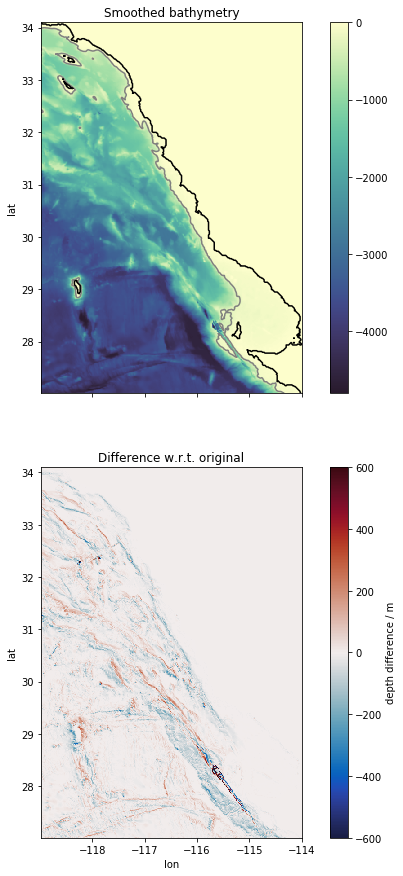

In [12]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(10,15), sharex=True)
pc = ax.pcolormesh(lon_vect[1:],lat_vect[1:], smooth_bathy, cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc, ax=ax)
ax.contour(lon_vect[1:],lat_vect[1:], -smooth_bathy, colors='0.5', levels=[250])
ax.contour( lon_vect[1:],lat_vect[1:], -smooth_bathy, colors='k', levels=[0])

pc1 = ax1.pcolormesh(lon_vect[1:], lat_vect[1:],
                     smooth_bathy-bathy[1:,1:], 
                     cmap=cmo.cm.balance, vmin=-600, vmax=600)
cb = plt.colorbar(pc1, ax=ax1)

cb.set_label('depth difference / m')
ax1.set_xlabel('lon')
ax.set_ylabel('lat')
ax1.set_ylabel('lat')
ax.set_title('Smoothed bathymetry')
ax1.set_title('Difference w.r.t. original')
ax.set_aspect(1)
ax1.set_aspect(1)

### Final clean up

Remove 1-cell islands and puddles on land

In [13]:
smooth_bathy[358,116]=smooth_bathy[358,117]
# uff, there's lots to fix...

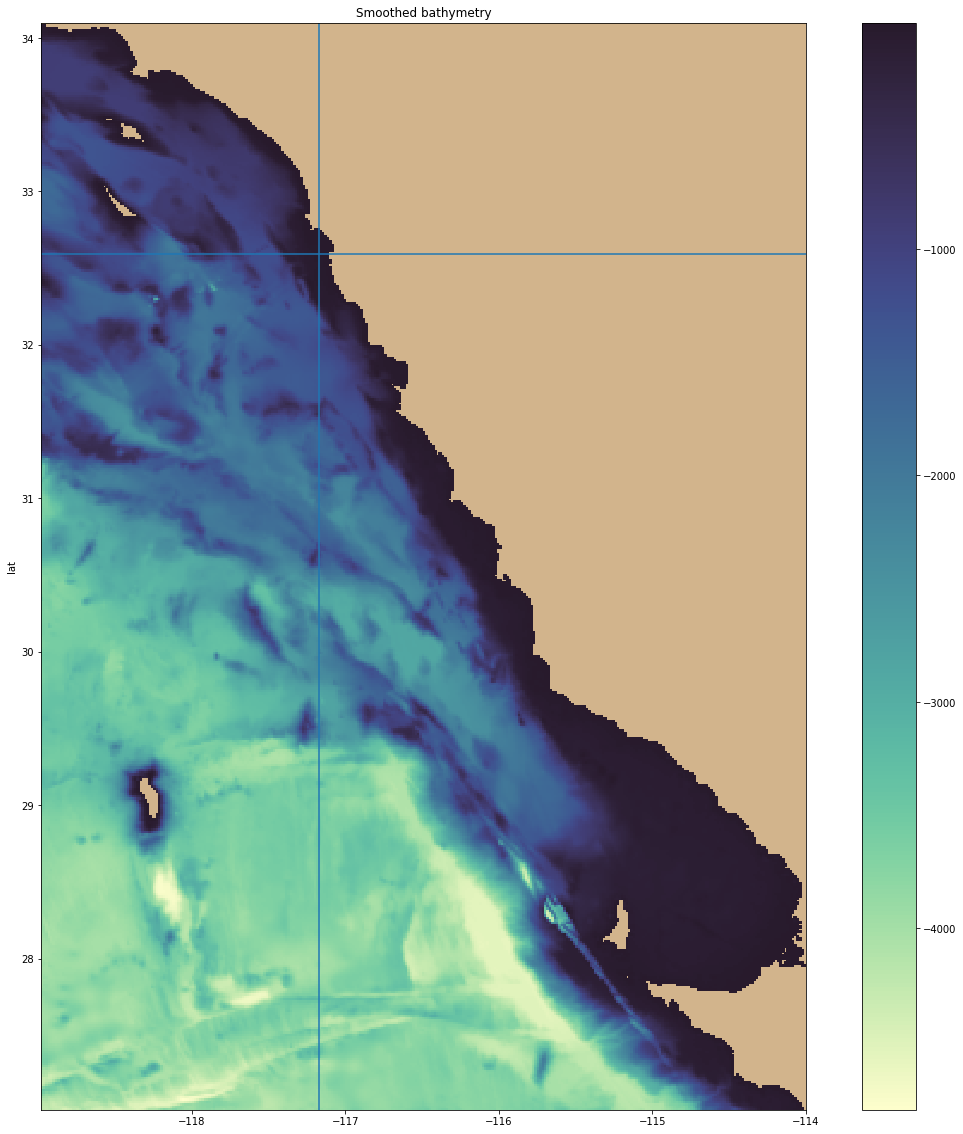

In [14]:
fig, (ax) = plt.subplots(1,1,figsize=(20,20), sharex=True)
mask_smooth = np.ma.masked_values(smooth_bathy,0)
mask = np.ma.getmask(mask_smooth)
ax.set_facecolor('tan')
pc = ax.pcolormesh(lon_vect[1:],lat_vect[1:], np.ma.masked_array(smooth_bathy, mask=mask), cmap=cmo.cm.deep)
cb = plt.colorbar(pc, ax=ax)
ax.axvline(lon_vect[117])
ax.axhline(lat_vect[359])

#ax.contour(lon_vect[1:],lat_vect[1:], -smooth_bathy, colors='0.5', levels=[250])
#ax.contour( lon_vect[1:],lat_vect[1:], -smooth_bathy, colors='k', levels=[0])
ax.set_ylabel('lat')
ax.set_title('Smoothed bathymetry')
ax.set_aspect(1)


### SMOOTH 

In [15]:
def smoothgrid(h,hmin,hmax,hmax_coast,rmax,n_filter_deep_topo,n_filter_final):
    '''Function adapted from 
       https://rydsphd.wordpress.com/2011/09/20/smoothing-function-used-for-bathymetry/
       Smooth the topography to get a maximum r factor = rmax.
       
       h: np. array (bathymetry, positive)
       hmin: float, cutoff value of bathymetry (0 m)
       hmax: float, max depth at which to cut off bathymetry (5000 m)
       n_filter_deep_topo: Number of pass of a selective filter to reduce the isolated 
                           seamounts on the deep ocean.
       n_filter_final: Number of pass of a single hanning filter at the end of the
                       procedure to ensure that there is no 2DX noise in the topography.
       Further Information: http://www.brest.ird.fr/Roms_tools/

       Updated    Aug-2006 by Pierrick Penven'''

    # Chop the topography at min and max values
    h[h<hmin] = hmin
    h[h>hmax] = hmax
    
    # Step 1: Deep Ocean Filter (remove isolated seamounts)
    if n_filter_deep_topo >= 1:
    #  Build a smoothing coefficient that is a linear function
    #  of a smooth topography.
        coef=h.copy()
        for i in range(8):
            coef=hanning_smoother(coef)    # coef is a smoothed bathy
        coef=0.125*(coef/np.nanmax(coef))     # rescale the smoothed bathy
    
        for i in range(n_filter_deep_topo):
            h=hanning_smoother_coef2d(h,coef)     # smooth with avariable coef
            h[h<hmax_coast] = hmax_coast

    # Apply a selective filter on log(h) to reduce grad(h)/h.
    h = rotfilter(h,hmax_coast,rmax)

    # Smooth the topography again to prevent 2D noise
    if n_filter_final > 1:
        for i in range(n_filter_final):
            h=hanning_smoother(h)
            #h[h>hmax_coast]=hmax_coast
    h[h<hmin]=hmin
    return(h)

def hanning_smoother(h):
    M,L = np.shape(h)[0], np.shape(h)[1]
    Mm = M-1
    Mmm = M-2
    Lm = L-1
    Lmm = L-2

    h[1:Mm,1:Lm]=0.125*(h[0:Mmm,1:Lm]+h[2:M,1:Lm]+
                        h[1:Mm,0:Lmm]+h[1:Mm,2:]+
                        4*h[1:Mm,1:Lm])
    h[0,:]=h[1,:]
    h[M-1,:]=h[Mm-1,:]
    h[:,0]=h[:,1]
    h[:,L-1]=h[:,Lm-1]
    return(h)

def hanning_smoother_coef2d(h,coef):
    M,L = np.shape(h)[0], np.shape(h)[1]
    Mm = M-1
    Mmm = M-2
    Lm = L-1
    Lmm = L-2
    h[1:Mm,1:Lm]=(coef[1:Mm,1:Lm]*(h[0:Mmm,1:Lm]+h[2:M,1:Lm]+
                                  h[1:Mm,0:Lmm]+h[1:Mm,2:L])+
                  (np.ones(np.shape(coef[1:Mm,1:Lm]))-4.*coef[1:Mm,1:Lm])*h[1:Mm,1:Lm])

    h[0,:]=h[1,:]
    h[M-1,:]=h[Mm-1,:]
    h[:,0]=h[:,1]
    h[:,L-1]=h[:,Lm-1]
    return(h)

def rfact(h):
    M, L = np.shape(h)[0], np.shape(h)[1]
    Mm = M-1
    Mmm = M-2
    Lm = L-1
    Lmm = L-2
    rx=abs(h[0:M,1:L]-h[0:M,0:Lm])/(h[0:M,1:L]+h[0:M,0:Lm])
    ry=abs(h[1:M,0:L]-h[0:Mm,0:L])/(h[1:M,0:L]+h[0:Mm,0:L])
    return(rx,ry)

def FX(h):
    M, L = np.shape(h)[0], np.shape(h)[1]
    Mm=M-1
    Mmm=M-2
    Lm=L-1
    Lmm=L-2

    fx[1:Mm,:]=((h[1:Mm,1:L]-h[1:Mm,0:Lm])*5/6 +
                (h[0:Mmm,1:L]-h[0:Mmm,0:Lm]+h[2:M,1:L]-h[2:M,0:Lm])/12)

    fx[0,:]=fx[1,:]
    fx[M-1,:]=fx[Mm-1,:]
    return(fx)

def FY(h):
    M, L = np.shape(h)[0], np.shape(h)[1]
    Mm=M-1
    Mmm=M-2
    Lm=L-1
    Lmm=L-2

    fy[:,1:Lm]=((h[1:M,1:Lm]-h[0:Mm,1:Lm])*5/6 +
                (h[1:M,0:Lmm]-h[0:Mm,0:Lmm]+h[1:M,2:L]-h[1:Mm,2:L])/12)
      
    fy[:,0]=fy[:,1]
    fy[:,L-1]=fy[:,Lm-1]

    return(fy)

def rotfilter(h,hmax_coast,rmax):
    '''Apply a selective filter on log(h) to reduce grad(h)/h.'''
    M, L = np.shape(h)[0], np.shape(h)[1]
    Mm=M-1
    Mmm=M-2
    Lm=L-1
    Lmm=L-2
    cff=0.8
    nu=3/16
    rx, ry = rfact(h)
    r = np.max(np.array(np.max(rx),np.max(ry)))
    h=np.log(h)
    #hmax_coast = np.log(hmax_coast)
    i=0
    while r>rmax:
        i=i+1
        cx = float(rx>cff*rmax)
        cx = hanning_smoother(cx)
        cy = float(ry>cff*rmax)
        cy = hanning_smoother(cy)
        fx = cx*FX(h)
        fy = cy*FY(h)
        h[1:Mm,1:Lm]=(h[1:Mm,1:Lm]+
                      nu*((fx[1:Mm,1:Lm]-fx[1:Mm,0:Lmm])+
                          (fy[1:Mm,1:Lm]-fy[0:Mmm,1:Lm])))
        h[0,:] = h[1,:]
        h[M-1,:] = h[M-1,:]
        h[:,0] = h[:,1]
        h[:,L-1] = h[:,Lm-1]
        #h[h>hmax_coast] = hmax_coast
        rx, ry = rfact(np.exp(h))
        r = np.max(np.array(np.max(rx),np.max(ry)))
    h = np.exp(h)
    return(h)



In [16]:
# deep filter = 10
hmin = 0
hmax = 5000
hmax_coast = 0
rmax = 0.5
n_filter_deep_topo = 10
n_filter_final = 1
h2 = -smooth_bathy.copy()
HH = smoothgrid(h2,hmin,hmax,hmax_coast,rmax,n_filter_deep_topo,n_filter_final)

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log


In [17]:
# deep filter = 100

hmin = 0
hmax = 5000
hmax_coast = 0
rmax = 0.5
n_filter_deep_topo = 100
n_filter_final = 1
h3 = -smooth_bathy.copy()
HH2 = smoothgrid(h3,hmin,hmax,hmax_coast,rmax,n_filter_deep_topo,n_filter_final)

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log


/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


Text(0.5, 1.0, 'smoothed x 100 - original')

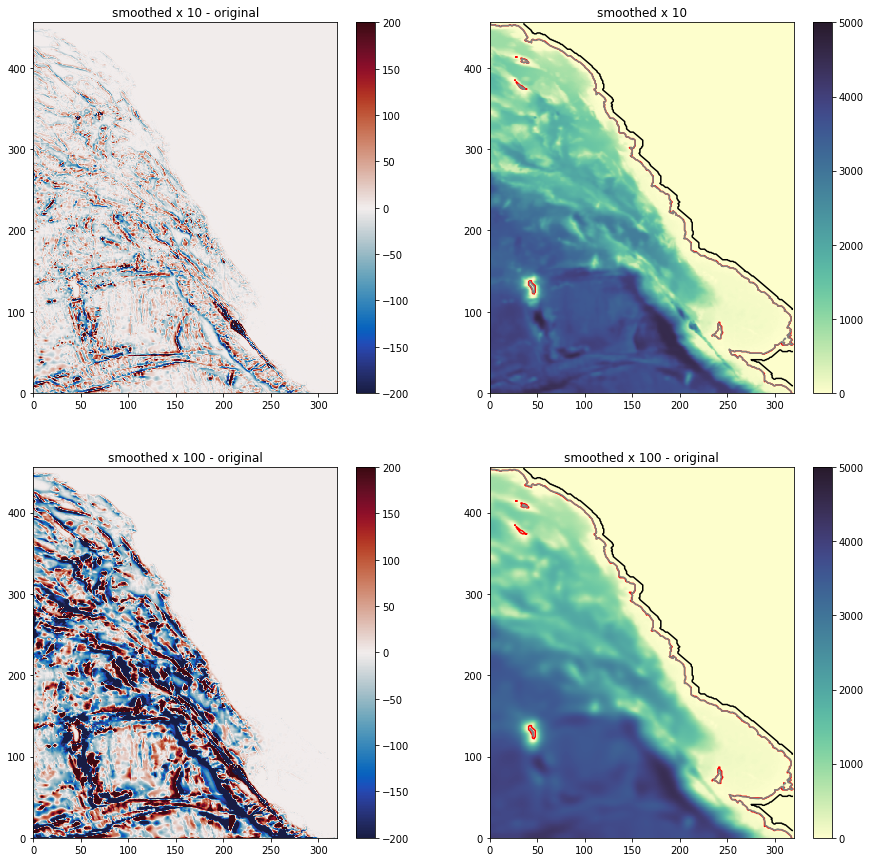

In [18]:
fig,((ax,axx),(ax2,ax3)) = plt.subplots(2,2, figsize=(15,15))

pc = ax.pcolormesh(HH-(-smooth_bathy), cmap=cmo.cm.balance, vmin=-200, vmax=200)
plt.colorbar(pc, ax=ax)
ax.set_title('smoothed x 10 - original')

pc2 = ax2.pcolormesh(HH2-(-smooth_bathy), cmap=cmo.cm.balance, vmin=-200, vmax=200)
plt.colorbar(pc2,ax=ax2)
ax2.set_title('smoothed x 100 - original')

pcx = axx.pcolormesh(HH, cmap=cmo.cm.deep, vmin=0, vmax=5000)
axx.contour(-smooth_bathy, levels=[0], colors='r')
axx.contour(HH, levels=[0], colors='k')
axx.contour(HH, levels=[0.1], colors='0.5')
plt.colorbar(pcx,ax=axx)
axx.set_title('smoothed x 10')

pc3 = ax3.pcolormesh(HH2, cmap=cmo.cm.deep, vmin=0, vmax=5000)
ax3.contour(-smooth_bathy, levels=[0], colors='r')
ax3.contour(HH2, levels=[0], colors='k')
ax3.contour(HH2, levels=[0.1], colors='0.5')
plt.colorbar(pc3,ax=ax3)
ax3.set_title('smoothed x 100 - original')

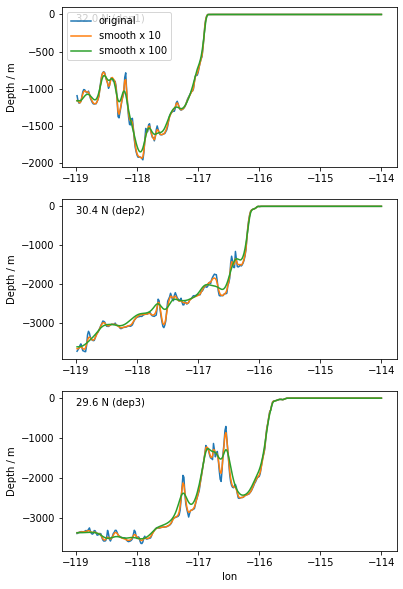

In [19]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1,figsize=(6,10))

lon_ind = 255
lat_ind1 = 70
lat_ind2 = 120
lon_ind_st = 10

# Cross-shelf bathymetry profiles OG
dep1 = smooth_bathy[lat_ind2+200,:]
dep2 = smooth_bathy[lat_ind2+100,:]
dep3 = smooth_bathy[lat_ind2+50,:]
ax1.plot(lon_vect[1:],dep1, label='original')
ax2.plot(lon_vect[1:],dep2, label='original')
ax3.plot(lon_vect[1:],dep3, label='original')

# Cross-shelf bathymetry profiles HH
dep1 = -HH[lat_ind2+200,:]
dep2 = -HH[lat_ind2+100,:]
dep3 = -HH[lat_ind2+50,:]
ax1.plot(lon_vect[1:],dep1, label='smooth x 10')
ax2.plot(lon_vect[1:],dep2, label='smooth x 10')
ax3.plot(lon_vect[1:],dep3, label='smooth x 10')

# Cross-shelf bathymetry profiles HH2
dep1 = -HH2[lat_ind2+200,:]
dep2 = -HH2[lat_ind2+100,:]
dep3 = -HH2[lat_ind2+50,:]
ax1.plot(lon_vect[1:],dep1, label='smooth x 100')
ax2.plot(lon_vect[1:],dep2, label='smooth x 100')
ax3.plot(lon_vect[1:],dep3, label='smooth x 100')

ax1.text(-119,-100,'%1.1f N (dep1)' %lat_vect[lat_ind2+200])
ax2.text(-119,-200,'%1.1f N (dep2)' %lat_vect[lat_ind2+100])
ax3.text(-119,-200,'%1.1f N (dep3)' %lat_vect[lat_ind2+50])

ax3.set_xlabel('lon')
ax1.set_ylabel('Depth / m')
ax2.set_ylabel('Depth / m')
ax3.set_ylabel('Depth / m')

ax1.legend(ncol=1)


In [20]:
HH_fix = HH.copy()
HH_fix[HH_fix<0.1] = 0

HH2_fix = HH2.copy()
HH2_fix[HH2_fix<0.1] = 0

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: No contour levels were found within the data range.


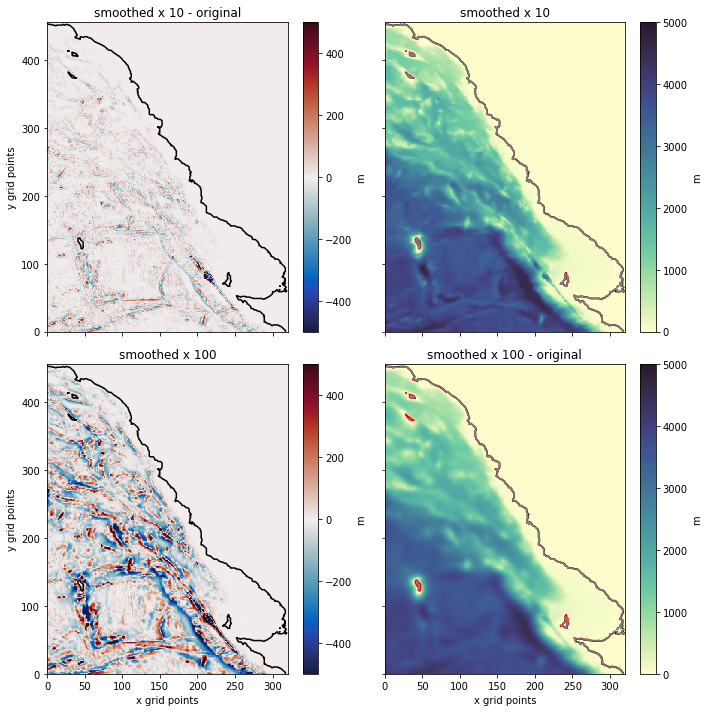

In [21]:
fig,((ax,axx),(ax2,ax3)) = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

pc = ax.pcolormesh(HH_fix-(-smooth_bathy), cmap=cmo.cm.balance, vmin=-500, vmax=500)
plt.colorbar(pc, ax=ax, label='m')
ax.contour(-smooth_bathy, levels=[0], colors='k')
ax.set_title('smoothed x 10 - original')

pc2 = ax2.pcolormesh(HH2_fix-(-smooth_bathy), cmap=cmo.cm.balance, vmin=-500, vmax=500)
plt.colorbar(pc2,ax=ax2, label='m')
ax2.contour(-smooth_bathy, levels=[0], colors='k')
ax2.set_title('smoothed x 100')

pcx = axx.pcolormesh(HH_fix, cmap=cmo.cm.deep, vmin=0, vmax=5000)
axx.contour(-smooth_bathy, levels=[0], colors='r')
axx.contour(HH_fix, levels=[0], colors='k')
axx.contour(HH_fix, levels=[0.1], colors='0.5')
plt.colorbar(pcx,ax=axx, label='m')
axx.set_title('smoothed x 10')

pc3 = ax3.pcolormesh(HH2_fix, cmap=cmo.cm.deep, vmin=0, vmax=5000)
ax3.contour(-smooth_bathy, levels=[0], colors='r')
ax3.contour(HH2_fix, levels=[0], colors='k')
ax3.contour(HH2_fix, levels=[0.1], colors='0.5')
plt.colorbar(pc3,ax=ax3, label='m')
ax3.set_title('smoothed x 100 - original')
ax3.set_xlabel('x grid points')
ax2.set_xlabel('x grid points')
ax2.set_ylabel('y grid points')
ax.set_ylabel('y grid points')
plt.tight_layout()

### Binary file

In [22]:
# Build grid spacing vectors dx and dy 
delx = lon_vect[1:]-lon_vect[:-1]
dely = lat_vect[1:]-lat_vect[:-1]
dx = np.append(delx, [delx[-1]], axis=0) # This is not the best way to do this
dy = np.append(dely, [dely[-1]], axis=0)

In [23]:
dy

array([0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01558, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01558, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557, 0.01557,
       0.01557, 0.01

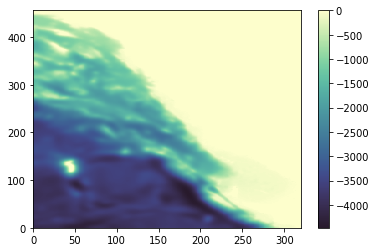

In [26]:
bathy_fname = '320x456/domain3_320x456_100xfilt_SVB_bat.bin'
dx_fname = '320x456/domain3_320x456_100xfilt_SVB_dx.bin'
dy_fname = '320x456/domain3_320x456_100xfilt_SVB_dy.bin'

dt = np.dtype('>f8')  # float 64 big endian

fileobj = open(dx_fname,mode='wb')
dx.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(dy_fname, mode='wb')
dy.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(bathy_fname, mode='wb')
dd=-HH2_fix
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

plt.pcolor(dd, cmap=cmo.cm.deep_r)
plt.colorbar()
plt.show()

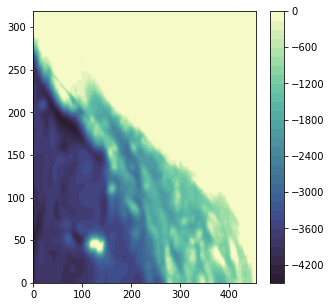

In [27]:
# Check it is read correctly
cc=np.fromfile(bathy_fname, dtype=dt)
np.shape(cc)

bF=np.reshape(cc,[nx,ny],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.contourf(bF, 40, cmap=cmo.cm.deep_r)
plt.colorbar(pc,ax=ax)
